In [1]:
%matplotlib inline
from edgenerator import make_graph
from biom import load_table
from jinja2 import Environment
from json import dumps
from skbio import DistanceMatrix

import pandas as pd
import numpy as np
import networkx as nx

In [2]:
def load_mf(fn):
    _df = pd.read_csv(fn, sep='\t', dtype=str, keep_default_na=False, na_values=[])
    _df.set_index('#SampleID', inplace=True)
    return _df

In [44]:
!scp barnacle:filtered.emp-90-gg-1k-unweighted_unifrac.txt .

/home/yovazquezbaeza/.bashrc: line 34: module: command not found
discarding /home/yovazquezbaeza/miniconda/bin from PATH
prepending /home/yovazquezbaeza/miniconda/envs/qiime/bin to PATH
filtered.emp-90-gg-1k-unweighted_unifrac.txt  100%  355MB  16.2MB/s   00:22    


In [45]:
!scp barnacle:/projects/emp/00-qiime-maps/merged/emp_qiime_mapping_all_emp.tsv .

/home/yovazquezbaeza/.bashrc: line 34: module: command not found
discarding /home/yovazquezbaeza/miniconda/bin from PATH
prepending /home/yovazquezbaeza/miniconda/envs/qiime/bin to PATH
emp_qiime_mapping_all_emp.tsv                 100%   18MB  18.2MB/s   00:01    


In [3]:
mf = load_mf('/Users/yoshikivazquezbaeza/Documents/PDF/KnightLaboratory/VazquezBaezaDogs/mapping-file-full.alpha.txt')
bt = load_table("/Users/yoshikivazquezbaeza/Documents/PDF/KnightLaboratory/VazquezBaezaDogs/otu_table.15000.no-diarrhea.biom")
dm = DistanceMatrix.read('/Users/yoshikivazquezbaeza/Documents/PDF/KnightLaboratory/VazquezBaezaDogs/beta/15000/unweighted_unifrac_dm.txt')

In [4]:
mf['latitude'] = pd.to_numeric(mf['latitude'], errors='coerce')
mf['longitude'] = pd.to_numeric(mf['longitude'], errors='coerce')

In [5]:
# add some noise :L
mf['latitude'] = mf['latitude'] + np.random.normal(size=len(mf))
mf['longitude'] = mf['longitude'] + np.random.normal(size=len(mf))

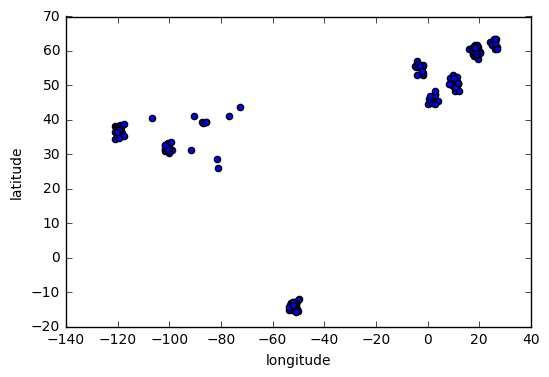

In [6]:
mf.plot('longitude', 'latitude', kind='scatter')

In [34]:
dict(zip(['a', 'b'], [1, 2]))

{'a': 1, 'b': 2}

In [36]:
# g = make_graph(bt, 2000)

g = nx.from_numpy_matrix(dm.data)
g = nx.relabel_nodes(g, dict(zip(g.nodes(), dm.ids)))
g = nx.minimum_spanning_tree(g)

g.number_of_nodes()

149

In [37]:
# get only these two columns as a dict, retrieving
# only samples present in the graph
attribs = mf[['latitude', 'longitude']].loc[g.nodes()].to_dict()

nx.set_node_attributes(g, 'latitude', attribs['latitude'])
nx.set_node_attributes(g, 'longitude', attribs['longitude'])

In [38]:
edges = []

for edge in g.edges_iter():
    u, v = edge
    edges.append({'origin': {'latitude': attribs['latitude'][u], 'longitude':attribs['longitude'][u]},
                  'destination': {'latitude': attribs['latitude'][v], 'longitude': attribs['longitude'][v]},
                  'taxonomy': g.get_edge_data(*edge)})

In [42]:
with open('template.html', 'r') as f:
    template = Environment().from_string(f.read())

with open('generated-minspan.html', 'w') as f:
    f.write(template.render(edge_data=dumps(edges)))